### IMPORTING LIBRARIES AND LOADING DATA

In [4]:
# Importing the relevant libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from surprise import Reader, Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [7]:
# !unzip ml-latest-small.zip

In [8]:
def load_and_join_csv(file_path_1, file_path_2, file_path_3):
    # Load CSV files into Pandas DataFrames
    movies = pd.read_csv(file_path_1)
    ratings = pd.read_csv(file_path_2)
    # tags = pd.read_csv(file_path_3)

    # Perform inner joins to combine the datasets based on common column movieId
    movies_ratings_df = pd.merge(movies, ratings, on='movieId', how='inner')

    return movies_ratings_df

# Replace 'file1.csv', 'file2.csv', 'file3.csv', and 'file4.csv' with your actual file paths
movie_rating_df = load_and_join_csv("ml-latest-small/movies.csv", "ml-latest-small/ratings.csv", "ml-latest-small/tags.csv")

# Display the resulting dataset
movie_rating_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


### DATA UNDERSTANDING

The dataset contains 6 columns and 100,836 entries. The 6 columns are

In [20]:
def examine_data(df):
    # Display the shape, columns and the first few rows of the dataset
    print("----------------------------Details about the data----------------------------\n ")
    print("----------------------------Shape of the dataset---------------------------- ")
    print(f"The dataset is a DataFrame with {df.shape[0]} rows and {df.shape[1]} columns\n")
    print("----------------------------Columns of the dataset---------------------------- ")
    display(df.columns)
    print("---------------------------- First 5 records of the dataset---------------------------- ")
    display(df.head())
    # Display information about the dataset
    print("\n----------------------------Data information ----------------------------")
    display(df.info())
    print("\n----------------------------Null Values ----------------------------")
    display(df.isnull().sum())
    print("\n----------------------------Duplicate Values ----------------------------")
    print(df.duplicated().sum(), 'duplicate values')
    return df


# Replace with your dataframe
df = examine_data(movie_rating_df)

----------------------------Details about the data----------------------------
 
----------------------------Shape of the dataset---------------------------- 
The dataset is a DataFrame with 100836 rows and 6 columns

----------------------------Columns of the dataset---------------------------- 


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

---------------------------- First 5 records of the dataset---------------------------- 


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483



----------------------------Data information ----------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


None


----------------------------Null Values ----------------------------


movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


----------------------------Duplicate Values ----------------------------
0 duplicate values


## EXPLORATORY DATA ANALYSIS
A brief statistical summary below of the numerical data provides insight into the distribution of the data by providing an overview of its central tendency and spread.

In [21]:
def data_analysis(df):
    display(df.describe())
    print('-------------Data Details---------------')
    print(f'Number of unique users:', movie_rating_df.userId.nunique())
    print(f'Number of unique movies:', movie_rating_df.movieId.nunique())

data_analysis(movie_rating_df)

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


-------------Data Details---------------
Number of unique users: 610
Number of unique movies: 9724


### UNIVARIATE DATA ANALYSIS
#### COUNT PLOTS

In [52]:

# A function to create plots

def create_plots(df, plot_type, columns_to_plot = None, y = None):
    if plot_type == 'count_plot':
        plt.figure(figsize=(12,8))
        sns.countplot(data=df, x=columns_to_plot)
        plt.title(f'Distribution of movie {columns_to_plot}')
        plt.xticks(rotation=90)
        plt.show()
    elif plot_type == 'bar_plot1':
        plt.figure(figsize=(12, 7))
        sns.barplot(x=columns_to_plot.index, y=columns_to_plot.values)
        plt.title('Top 10 most frequently rated movies')
        plt.xlabel('Movie tile')
        plt.xticks(rotation=90)
        plt.ylabel('Count')
        plt.show()
    elif plot_type == 'bar_plot2':
        plt.figure(figsize=(12, 7))
        sns.barplot(x=columns_to_plot.index, y=columns_to_plot.values)
        plt.title('Top 10 most frequently rated movies and their average ratings')
        plt.xlabel('Movie tile')
        plt.xticks(rotation=90)
        plt.ylabel('Average Rating')
        plt.show()

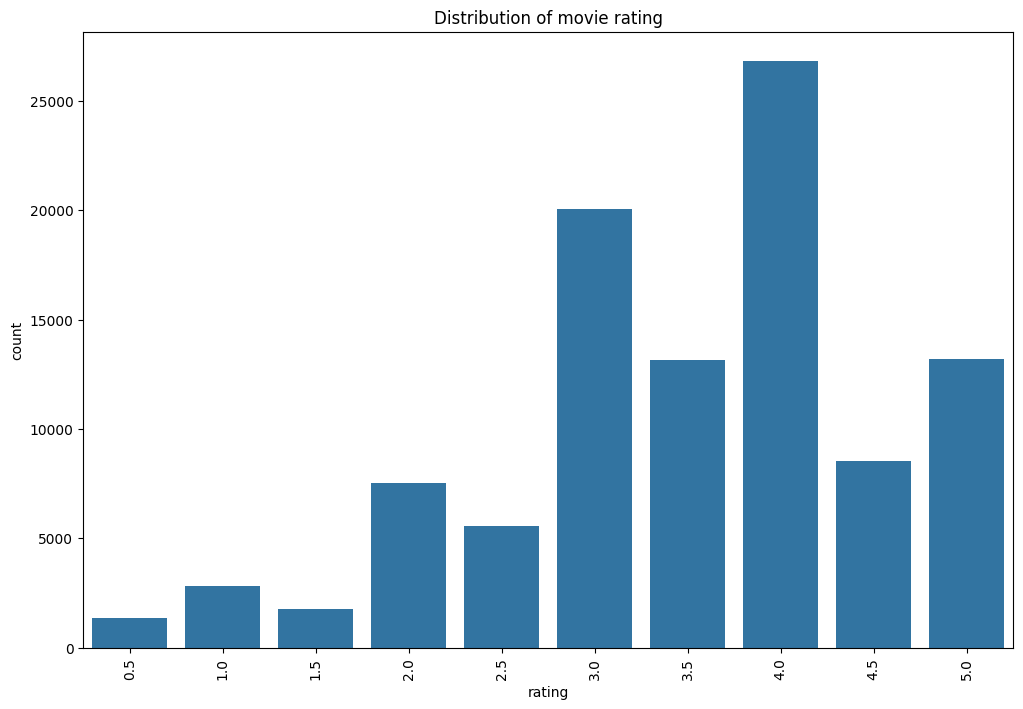

In [53]:
create_plots(movie_rating_df, 'count_plot', 'rating')

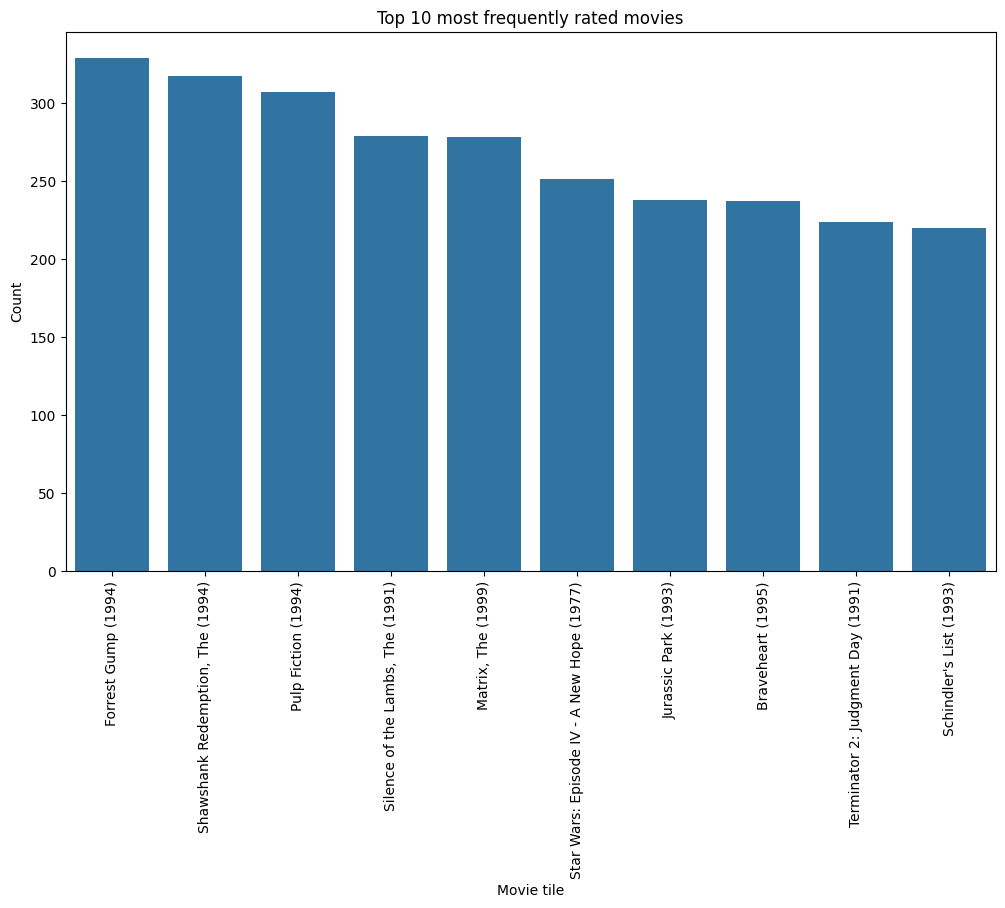

In [24]:
top_10_views = movie_rating_df['title'].value_counts().head(10)

create_plots(movie_rating_df, 'bar_plot1', top_10_views)

In [25]:
# Splitting the genres
def splitting_string(movies):
    movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
    from collections import Counter
    genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

    return genre_frequency

splitting_string(movie_rating_df)

Counter({'Adventure': 24161,
         'Animation': 6988,
         'Children': 9208,
         'Comedy': 39053,
         'Fantasy': 11834,
         'Romance': 18124,
         'Drama': 41928,
         'Action': 30635,
         'Crime': 16681,
         'Thriller': 26452,
         'Horror': 7291,
         'Mystery': 7674,
         'Sci-Fi': 17243,
         'War': 4859,
         'Musical': 4138,
         'Documentary': 1219,
         'IMAX': 4145,
         'Western': 1930,
         'Film-Noir': 870,
         '(no genres listed)': 47})

In [26]:
exploded_genres_df = movie_rating_df.copy()
exploded_genres_df = exploded_genres_df.explode('genres')
exploded_genres_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure,1,4.0,964982703
0,1,Toy Story (1995),Animation,1,4.0,964982703
0,1,Toy Story (1995),Children,1,4.0,964982703
0,1,Toy Story (1995),Comedy,1,4.0,964982703
0,1,Toy Story (1995),Fantasy,1,4.0,964982703
...,...,...,...,...,...,...
100832,193583,No Game No Life: Zero (2017),Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action,184,3.5,1537110021
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Animation,184,3.5,1537110021


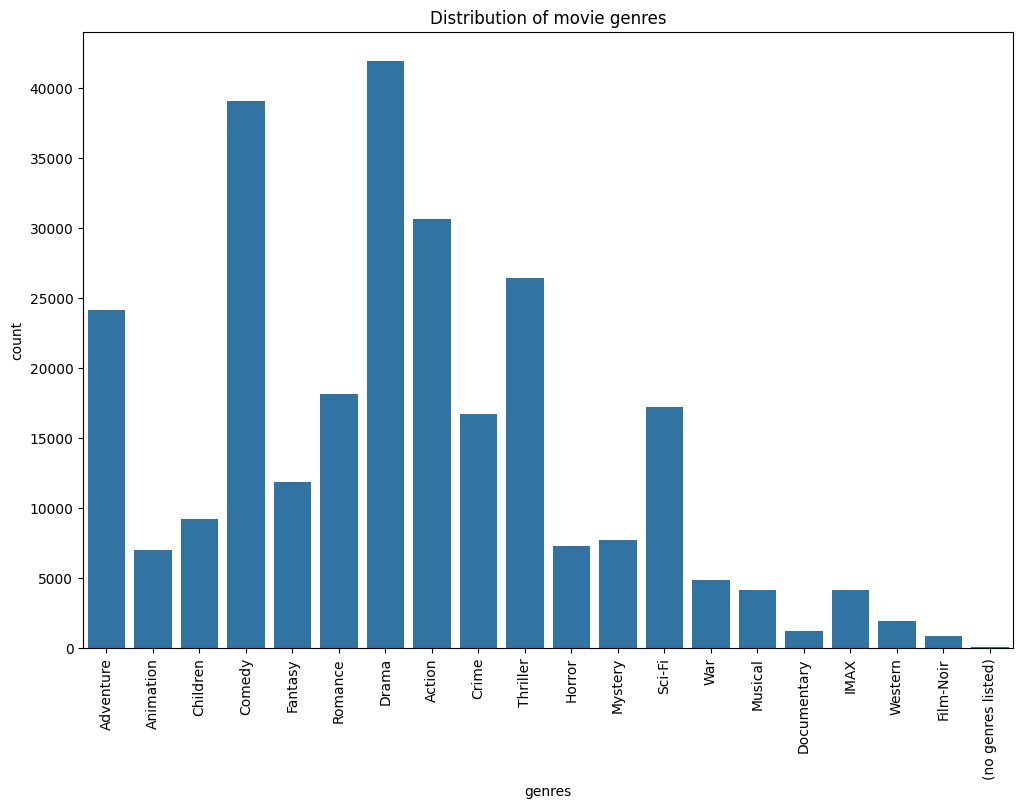

In [27]:

create_plots(exploded_genres_df, 'count_plot', 'genres')

### 2. BIVARIATE DATA ANALYSIS

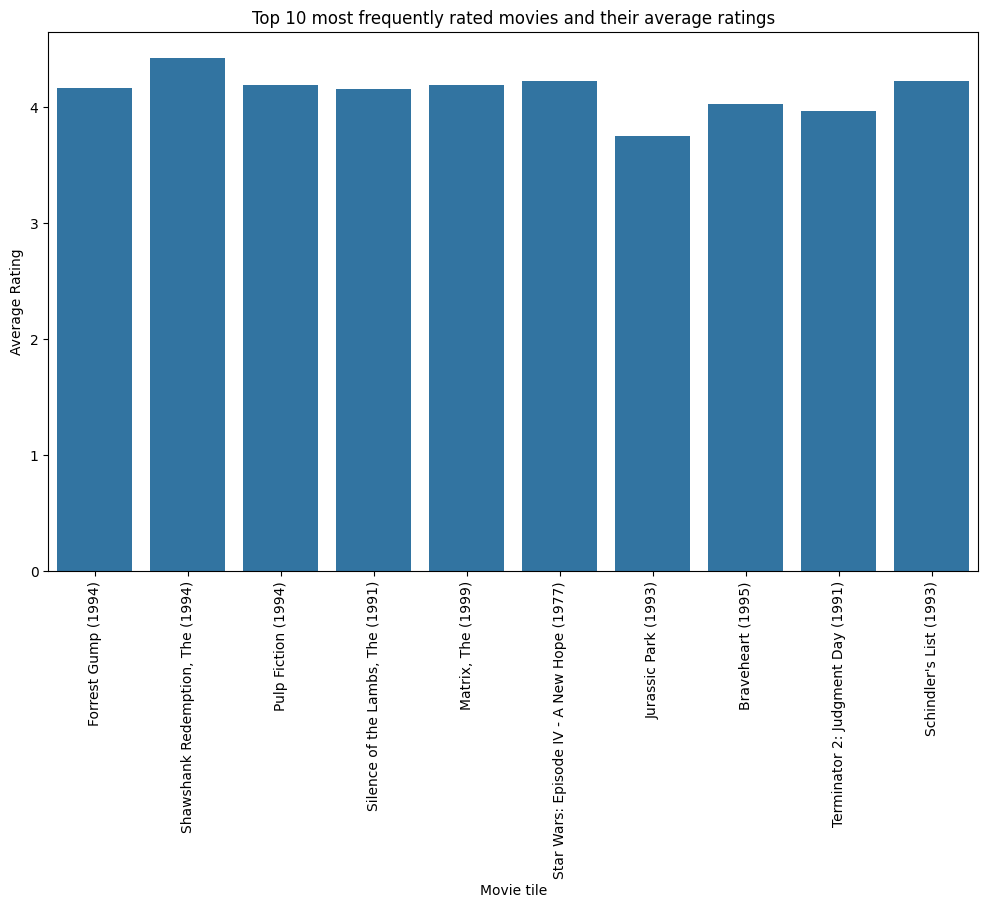

In [28]:
top_10_views = movie_rating_df['title'].value_counts().nlargest(10)
average_ratings = movie_rating_df.groupby('title')['rating'].mean().loc[top_10_views.index]


create_plots(movie_rating_df, 'bar_plot2', average_ratings)

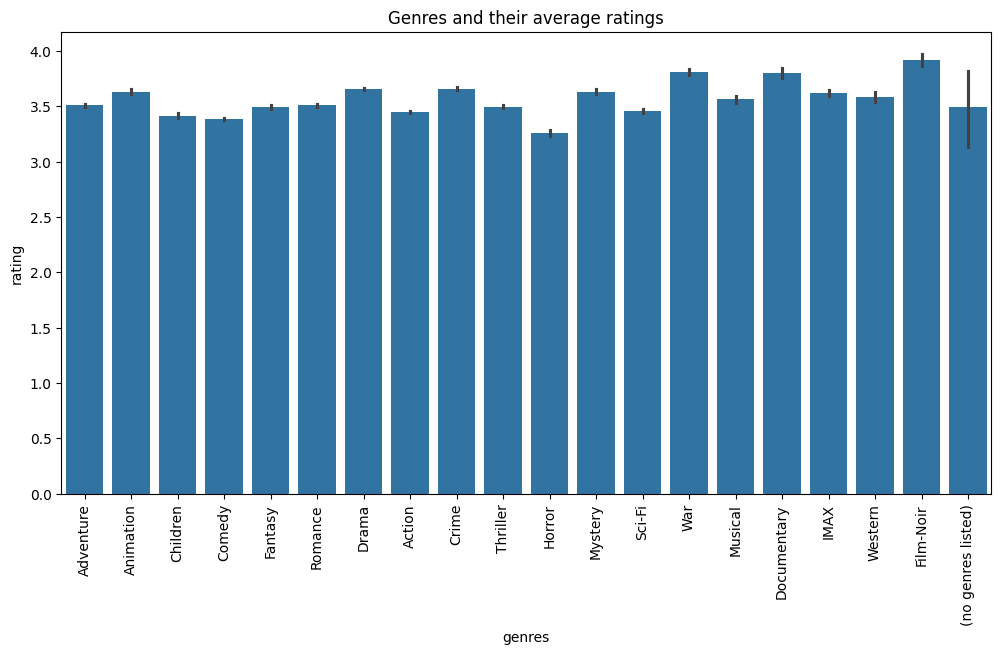

In [29]:
def bar_plot(x, y, data):

    plt.figure(figsize=(12,6))

    sns.barplot(x=x, y=y, data=data)
    plt.title('Genres and their average ratings')
    plt.xlabel(f'{x}')
    plt.xticks(rotation=90)
    plt.ylabel(f'{y}')
    plt.show()

bar_plot('genres', 'rating', exploded_genres_df)

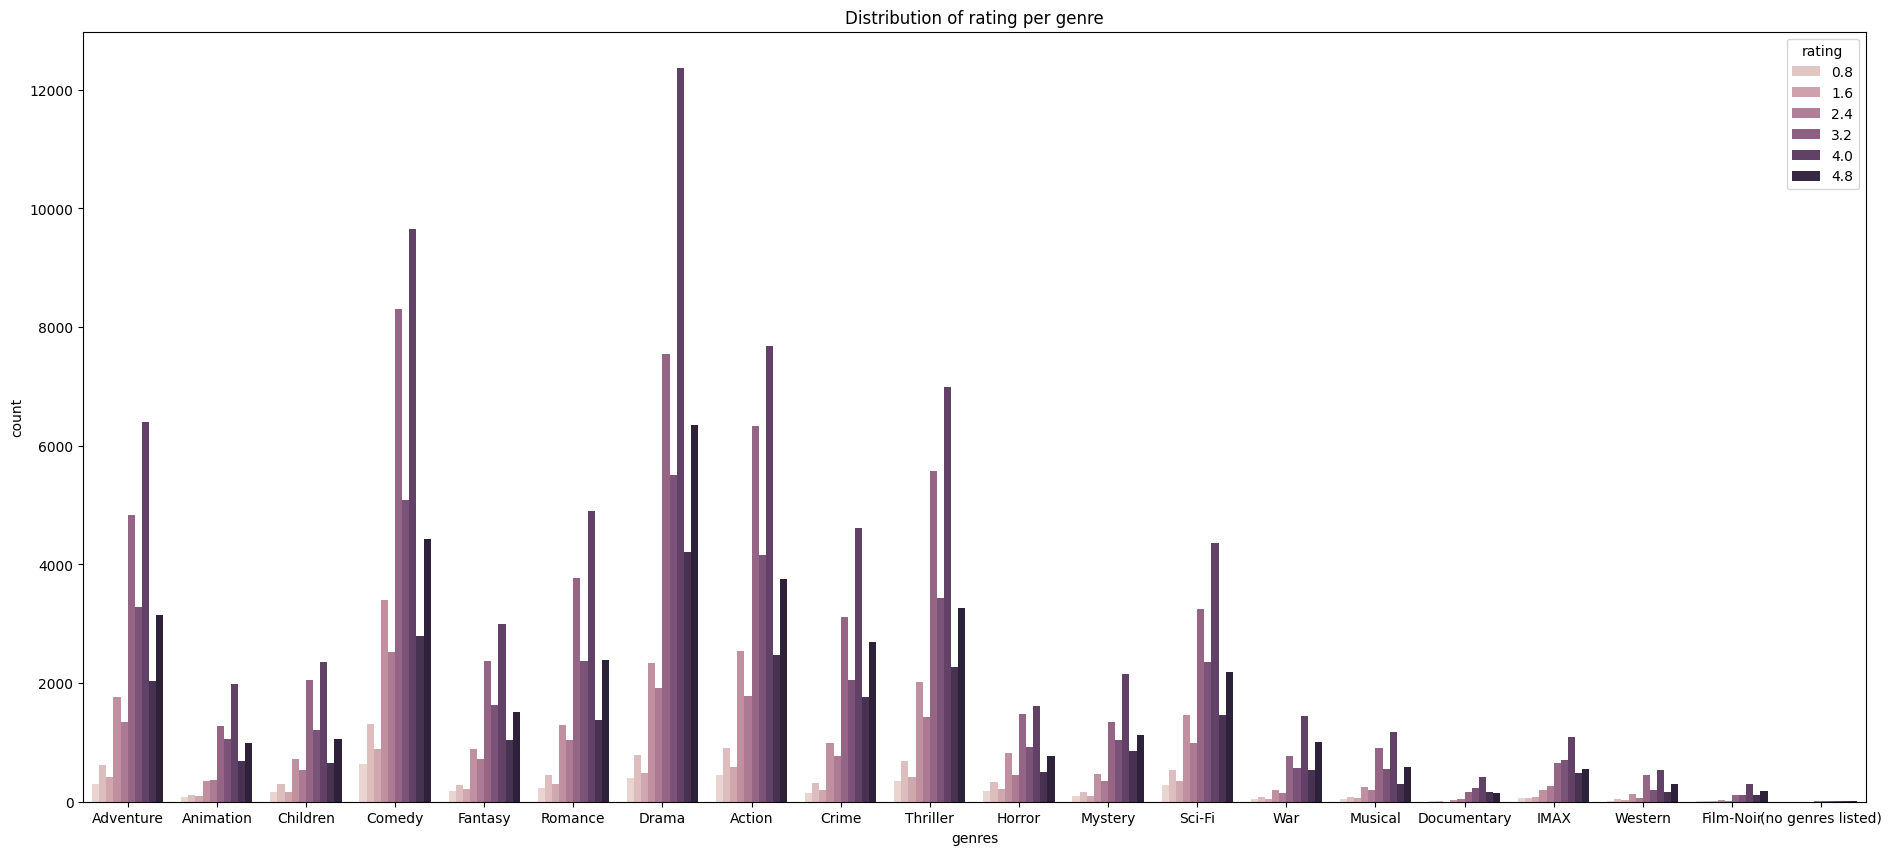

In [30]:
plt.figure(figsize=(23,10))
sns.countplot(data=exploded_genres_df, x='genres', hue='rating')
plt.title(f'Distribution of rating per genre')
plt.show()

## DATA PREPROCESSING

In [31]:
movie_rating_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,964982703
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,847434962
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1106635946
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1510577970
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",184,3.5,1537109545
100833,193585,Flint (2017),[Drama],184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",184,3.5,1537110021


## MODELLING

In [103]:
movie_rating_df[['userId', 'movieId', 'rating']]

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5
...,...,...,...
100831,184,193581,4.0
100832,184,193583,3.5
100833,184,193585,3.5
100834,184,193587,3.5


In [32]:
# Select the necessary columns from the dataset
user_item_df = movie_rating_df[['userId', 'movieId', 'rating']]

# Transform the pandas dataframe into Surprise dataset
reader = Reader()
data = Dataset.load_from_df(user_item_df, reader)

# Split into train and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=111)

# Print the number of unique users and items in the dataset
print("Number of users: ", trainset.n_users, "\n")
print("Number of items: ", trainset.n_items, "\n")

Number of users:  610 

Number of items:  8995 



### MODELING FUNCTION

### MODEL 1: KNN BASIC MODEL

In [33]:
# Function to create the model
def model_creation(approach, trainset, testset):
    if approach == SVD:
        model = approach(n_factors= 50, reg_all=0.05)
        model.fit(trainset)
        print(f'{approach.__name__} RMSE:', accuracy.rmse(model.test(testset)))
    else:
        model = approach(sim_options={'name':'pearson', 'user_based':True})
        model.fit(trainset)
        print(f'{approach.__name__} RMSE:', accuracy.rmse(model.test(testset)))

In [34]:
# Build a KNNBasic model
model_creation(KNNBasic, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9721
KNNBasic RMSE: 0.9720846164183417


#### Tune the KNNBasic Model

In [37]:
def param_grid_search(model_to_tune):

    # Setting relevant parameters for Gridsearch
    grid = {
        'k': [30, 40],   # Number of neighbors
        'sim_options': {
            'name': ['cosine', 'pearson'],  # Similarity measures
            'user_based': [True],  # User-based collaborative filtering
        },
    }
    # Creating a parameter grid search for SVD model
    params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1],
        #  'n_epochs': [5,10],
        # 'lr_all': [0.002,0.005]
         }

    # Running grid search with the defined parameter grid
    if model_to_tune == SVD:
        grid_search = GridSearchCV(model_to_tune, params,
                                    measures=['rmse'], n_jobs=-1)
    else:
        grid_search = GridSearchCV(model_to_tune, grid,
                                    measures=['rmse'], n_jobs=-1)
    grid_search.fit(data)
    print(f"Best RMSE for {model_to_tune.__name__}: {grid_search.best_score}")
    print(f"Best Hyperparameters for {model_to_tune.__name__}: {grid_search.best_params}")
    return grid_search.best_estimator



In [38]:
# Grid search for KNNBasic Model
param_grid_search(KNNBasic)

Best RMSE for KNNBasic: {'rmse': 0.9721413914274578}
Best Hyperparameters for KNNBasic: {'rmse': {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}}}


{'rmse': <surprise.prediction_algorithms.knns.KNNBasic at 0x7c26338621d0>}

### MODEL 2: KNNBaseline Model

In [39]:
# Build a KNNBaseline model
model_creation(KNNBaseline, trainset, testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8790
KNNBaseline RMSE: 0.8789611074934803


#### Tune the KNNBaseline Model

In [40]:
# Grid search for KNNBaseline Model
param_grid_search(KNNBaseline)

Best RMSE for KNNBaseline: {'rmse': 0.8766628117869703}
Best Hyperparameters for KNNBaseline: {'rmse': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}}


{'rmse': <surprise.prediction_algorithms.knns.KNNBaseline at 0x7c263709c970>}

### MODEL 3: KNNWithMeans Model

In [41]:
# Build a KNNWithMeans model
model_creation(KNNWithMeans, trainset, testset)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8995
KNNWithMeans RMSE: 0.8994971701396823


#### Tune the KNNWithMeans Model

In [42]:
# Grid search for KNNWithMeans Model
param_grid_search(KNNWithMeans)

Best RMSE for KNNWithMeans: {'rmse': 0.8961162131066314}
Best Hyperparameters for KNNWithMeans: {'rmse': {'k': 40, 'sim_options': {'name': 'pearson', 'user_based': True}}}


{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans at 0x7c26782bee90>}

### MODEL 4: SVD Model

In [43]:
# Build a SVD model
model_creation(SVD, trainset, testset)

RMSE: 0.8696
SVD RMSE: 0.8695855880123571


In [44]:
# Grid search for KNNWithMeans Model
svd_best_model = param_grid_search(SVD)

Best RMSE for SVD: {'rmse': 0.869569767152034}
Best Hyperparameters for SVD: {'rmse': {'n_factors': 50, 'reg_all': 0.05}}


##### Best Hyperparameters for SVD: {'rmse': {'n_factors': 20, 'reg_all': 0.02}}

### FINAL MODEL SELECTION AND EVALUATION

SVD model performed best as compared to the rest of the models with a RMSE of 0.8688.

In [45]:
# A table that displays a summary of the validation metrics
def make_evaluation_table(metrics_dict):
    metrics_df = pd.DataFrame(metrics_dict)
    evaluation_table = metrics_df.to_html(index=False)
    return evaluation_table

metrics_dict = {
    'Model': ['KNNBasic', 'KNNBaseline', 'KNNWithMeans', 'SVD'],
    'RMSE': [0.9721, 0.8790, 0.8995, 0.8688],
    'RMSE after Tuning': [0.9719, 0.8776, 0.8964, 0.8691],
    }

evaluation_table = make_evaluation_table(metrics_dict)
HTML(evaluation_table)

Model,RMSE,RMSE after Tuning
KNNBasic,0.9721,0.9719
KNNBaseline,0.8790,0.8776
KNNWithMeans,0.8995,0.8964
SVD,0.8688,0.8691


### PREDICTIONS

###### Initialize SVD with the optimal parameters

In [120]:
svd = SVD(n_factors=20, reg_all=0.02)
svd.fit(trainset)

###### make predictions

In [47]:
predictions = svd.test(testset)

###### check performance

In [48]:
rmse = accuracy.rmse(predictions)
print("Test RMSE: {:.4f}".format(rmse))

RMSE: 0.8723
Test RMSE: 0.8723


In [49]:
#find predicted rating of user_id 1 for movie_id 1
user_id = 1
movie_id = 1

svd.predict(user_id, movie_id).est

4.7350291144521695

In [50]:
prediction_list = [(prediction.uid, prediction.iid, prediction.est) for prediction in predictions]
sorted_predictions = sorted(prediction_list, key=lambda x: x[2], reverse=True)
# sorted_predictions

In [51]:
def get_seen_movies(user_id):
    """
    Retrieve a list of movie titles seen by a specific user.

    Parameters:
    - user_id (int): The unique identifier of the user.
    - movies_df (pd.DataFrame): DataFrame containing movie data with columns 'userId' and 'title'.

    Returns:
    - list: A list of movie titles seen by the specified user.
    """

    # Filter rows based on the user_id and extract the 'title' column as a list
    seen_movies = movie_rating_df[movie_rating_df['userId'] == user_id]['title'].to_list()

    return seen_movies

In [52]:
user_id = 700
seen_movies = get_seen_movies(user_id)
# seen_movies

In [53]:
unrated_movies = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in svd.trainset.all_items() if movie_id not in seen_movies and svd.predict(user_id, movie_id).est > 3.5]
unrated_movies.sort(key=lambda x: x[1], reverse=True)
unrated_movies[:5]


[(750, 4.403495239644292),
 (318, 4.394613961240873),
 (904, 4.356630716991352),
 (1204, 4.346734147662793),
 (50, 4.3320482929255)]

In [54]:
recommended_movies = [(user, movie, rating) for (user, movie, rating) in sorted_predictions if movie not in seen_movies]
recommended_movies[:9]

[(171, 1208, 5),
 (452, 1221, 5),
 (171, 858, 5),
 (337, 50, 5),
 (43, 47, 5),
 (122, 56782, 5),
 (452, 608, 5),
 (337, 318, 5),
 (276, 260, 5)]

In [55]:
movie_rating_df[movie_rating_df['movieId']==1208]['title'].unique()[0]

'Apocalypse Now (1979)'

In [124]:
def get_recommendations(user_id,n=5,threshold=3):
  seen_movies = get_seen_movies(user_id)
  unrated_movies = [(movie_id, svd.predict(user_id, movie_id).est) for movie_id in svd.trainset.all_items() if movie_id not in seen_movies and svd.predict(user_id, movie_id).est >= threshold]
  unrated_movies.sort(key=lambda x: x[1], reverse=True)
  n_recommended_movies = unrated_movies[:n+1]
  print(n_recommended_movies)
  return [movie_rating_df[movie_rating_df['movieId']==tup[0]]['title'].unique()[0] for tup in n_recommended_movies]

get_recommendations(user_id=111,n=5)

[(247, 4.409389882946386), (3275, 4.350020989206259), (356, 4.346405705451443), (1204, 4.295651742229244), (3037, 4.279273943918077), (1228, 4.273570965351029)]


['Heavenly Creatures (1994)',
 'Boondock Saints, The (2000)',
 'Forrest Gump (1994)',
 'Lawrence of Arabia (1962)',
 'Little Big Man (1970)',
 'Raging Bull (1980)']

In [104]:
import pickle

In [107]:
filename = 'model.sav'
pickle.dump(svd, open(filename, 'wb'))

In [108]:
load_model = pickle.load(open(filename, 'rb'))

In [110]:
load_model.predict(1,9)

Prediction(uid=1, iid=9, r_ui=None, est=3.9970788456081037, details={'was_impossible': False})

In [119]:
movie_rating_df

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,964982703,1995.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,847434962,1995.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,1106635946,1995.0
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,1510577970,1995.0
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,1305696483,1995.0
...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",184,4.0,1537109082,2017.0
100832,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",184,3.5,1537109545,2017.0
100833,193585,Flint (2017),[Drama],184,3.5,1537109805,2017.0
100834,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",184,3.5,1537110021,2018.0


In [118]:
pd.read_csv('ml-latest-small/movies.csv')

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [17]:
movie_rating_df.tail()

,movieId,title,genres,userId,rating,timestamp
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021
100835,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,331,4.0,1537157606


### Content Based Recommendation

In [25]:
movies = pd.read_csv('ml-latest-small/movies.csv')

In [75]:
movies.sample(10)

,movieId,title,genres
1739,2334,"Siege, The (1998)",Action|Thriller
4226,6153,Zapped! (1982),Comedy|Sci-Fi
3762,5248,Smokey and the Bandit III (1983),Action|Comedy
4784,7123,Naked Lunch (1991),Drama|Fantasy|Mystery|Sci-Fi
100,113,Before and After (1996),Drama|Mystery
3485,4759,Two Can Play That Game (2001),Comedy|Drama
1220,1620,Kiss the Girls (1997),Crime|Drama|Mystery|Thriller
965,1266,Unforgiven (1992),Drama|Western
584,719,Multiplicity (1996),Comedy
4799,7151,Girl with a Pearl Earring (2003),Drama|Romance


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import KNNBasic

In [76]:
content_df = movies[['movieId', 'title', 'genres']]
content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

In [77]:
movie_mapper = dict(zip(movies['title'], movies.index))

In [78]:
movie_mapper['Flint (2017)']

9739

In [54]:
# movie_mapper

In [79]:
tfidf_vectorizer = TfidfVectorizer(max_features=200)
content_matrix = tfidf_vectorizer.fit_transform(content_df['Content'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movie_rating_df[['userId', 'movieId', 'rating']], reader)

trainset, _ = train_test_split(data, test_size=0.2)
model = KNNBasic(sim_options={'name': 'cosine', 'user_based': False})
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [70]:
content_matrix

<100836x200 sparse matrix of type '<class 'numpy.float64'>'
	with 500698 stored elements in Compressed Sparse Row format>

In [92]:

def get_movie_recommendations(movie, n):

    idx = movie_mapper[movie]
    print('Movie Index: ',idx)
    movie_index = content_matrix[idx]
    print('Index: ', type(movie_index))
    scores = cosine_similarity(movie_index, content_matrix)
    scores = scores.flatten()
    print('Scores: ',scores)

    recommended_idx = (-scores).argsort()[1:n+1]
    print("Rec: ",recommended_idx)
    return movies['title'].iloc[recommended_idx]
    # recommended_titles = movies.loc[movies['movieId'].isin([1,2,56,7]), 'title']
    # print("Recommended Titles:")
    # print(recommended_titles)

user_input = "Andrew Dice Clay: Dice Rules (1991)"
recommendations = get_movie_recommendations(user_input, 9)
print(recommendations)

Movie Index:  9741
Index:  <class 'scipy.sparse._csr.csr_matrix'>
Scores:  [0.06634336 0.         0.0817773  ... 0.         0.         1.        ]
Rec:  [5561 3963  843 8577 3137 2105 2774 3811 5045]
5561                   Dutch (1991)
3963    Ernest Scared Stupid (1991)
843                    Loser (1991)
8577              Ski School (1991)
3137     Necessary Roughness (1991)
2105         Problem Child 2 (1991)
2774                Soapdish (1991)
3811               Delirious (1991)
5045              Highway 61 (1991)
Name: title, dtype: object


In [93]:
# model.get_neighbors(2, k=5)
# top_indices

In [98]:
# movie_rating_df
# movie_rating_df['year'] = movie_rating_df['title'].str.extract(r'\((\d{4})\)')
# movie_rating_df['year'] = pd.to_numeric(movie_rating_df['year'], errors='coerce')
# filtered_df = movie_rating_df.drop_duplicates(subset='title')
# filtered_df = filtered_df[filtered_df['year'] >= 2018]
# filtered_df

In [ ]:
# def movie_rater(movie_df,num, genre=None):
#     userID = 1000
#     rating_list = []
#     while num > 0:
#         if genre:
#             movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
#         else:
#             movie = movie_df.sample(1)
#         print(movie)
#         rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
#         if rating == 'n':
#             continue
#         else:
#             rating_one_movie = {'userId':userID,'movieId':movieId':movie['movieId'].values[0],'rating':rating}
#             rating_list.append(rating_one_movie)
#             num -= 1
#     return rating_list

In [113]:
# Streamlit UI
import streamlit as st
st.title('Movie Recommendation App')

# User input for selecting a movie
selected_movie = st.selectbox('Select a movie:', movie_data['title'])

# Get the corresponding movie ID
selected_movie_id = movie_id_mapping[selected_movie]

# User input for entering a user ID
user_id = st.number_input('Enter your user ID:', min_value=1, max_value=1000, value=1, step=1)

# Button to get recommendations
if st.button('Get Recommendations'):
    # Get the top 5 movie recommendations for the selected user and movie
    recommendations = [(movie_data[movie_data['movie_id'] == movie_id]['title'].values[0], svd_model.predict(user_id, movie_id).est)
                       for movie_id in movie_data['movie_id'].unique()]

    # Sort the recommendations by predicted rating in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    st.write('Top 5 Recommendations:')
    for i, (movie, rating) in enumerate(recommendations[:5]):
        st.write(f"{i+1}. {movie} (Predicted Rating: {rating:.2f})")

2024-01-18 02:47:07.787 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


NameError: name 'movie_data' is not defined

In [116]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.133.165.57:8501

  Stopping...
^C
